In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [78]:
#pre-processing data tables - data is read into separate files and then transposed to have the sample names on the left hand side so that they can be fed into the classifier properly

data = pd.read_csv("TCE_feature_table.csv")
labels = pd.read_csv("TCE_metadata.csv")

data_df = pd.DataFrame(data)
data_df = data_df.drop(labels = ["Sample"], axis = 1)
data_df = pd.DataFrame.transpose(data_df)

labels_df = pd.DataFrame(labels)
labels_df = labels_df[["TCE_Exp_Category"]]
labels_df.index = list(data_df.index)

data_df = data_df.fillna('0')

print("Data:\n", data_df)
print("Labels:\n", labels_df)

Data:
                 0             1              2             3             4     \
X1014   91281.128678  2.036870e+07  100801.729748  28578.671642  64506.008136   
X1049  295971.187048  2.364565e+07   147630.84046             0  36993.152512   
X1068  244257.923995  2.754199e+07  128838.317479  42871.285598   64365.24175   
X1070   82883.827703  2.019781e+07   48201.572085   45854.92046  21970.253718   
X1071  357387.911235  2.069844e+07   14503.911432  31862.665469  22431.697984   
...              ...           ...            ...           ...           ...   
X2204  149421.602081  2.326146e+07  113216.846541  37778.211692             0   
X2205  316785.129812  2.252470e+07  175605.835277  15896.028347  41628.632895   
X2207  267762.852536  2.074907e+07   58204.870888             0  49299.555895   
X2208  432355.324265  2.362341e+07   39426.444151  24436.256522  49749.324282   
X2209  295430.297093  1.960256e+07   56656.780775  25098.898492  54592.247426   

               5    

In [79]:
#Now we have to convert all the labels from categorical to numerical to assist the ML model

labels_df["TCE_Exp_Category"].replace(["Low", "Moderate", "High"], [1, 2, 3], inplace = True)
print(labels_df)

       TCE_Exp_Category
X1014                 1
X1049                 1
X1068                 1
X1070                 1
X1071                 1
...                 ...
X2204                 1
X2205                 1
X2207                 1
X2208                 1
X2209                 1

[175 rows x 1 columns]


In [80]:
#reducing the number of factors we're looking at by getting rid of any columns that have a high correlation with another column. This will help us use columns that have only distinct trends so that it can help with further classifying our data.

cor_data = data_df.corr()

print(data_df.shape)

for x in cor_data:
    for element in cor_data[x]:
        if element < 1 and element >= 0.80: # we use this as our condition so we don't get rid of every row. If we set element <= 1, then we would end up getting rid of every single row as every element correlates perfectly with itself.
            data_df = data_df.drop(x, axis=1)
            break

print(data_df.shape)

#after this round of processing, we can see that we got rid of approximately 600 rows that had high correlations. 
            

(175, 7830)
(175, 7264)


In [6]:
labels_df['TCE_Exp_Category'].value_counts()

1    95
3    41
2    39
Name: TCE_Exp_Category, dtype: int64

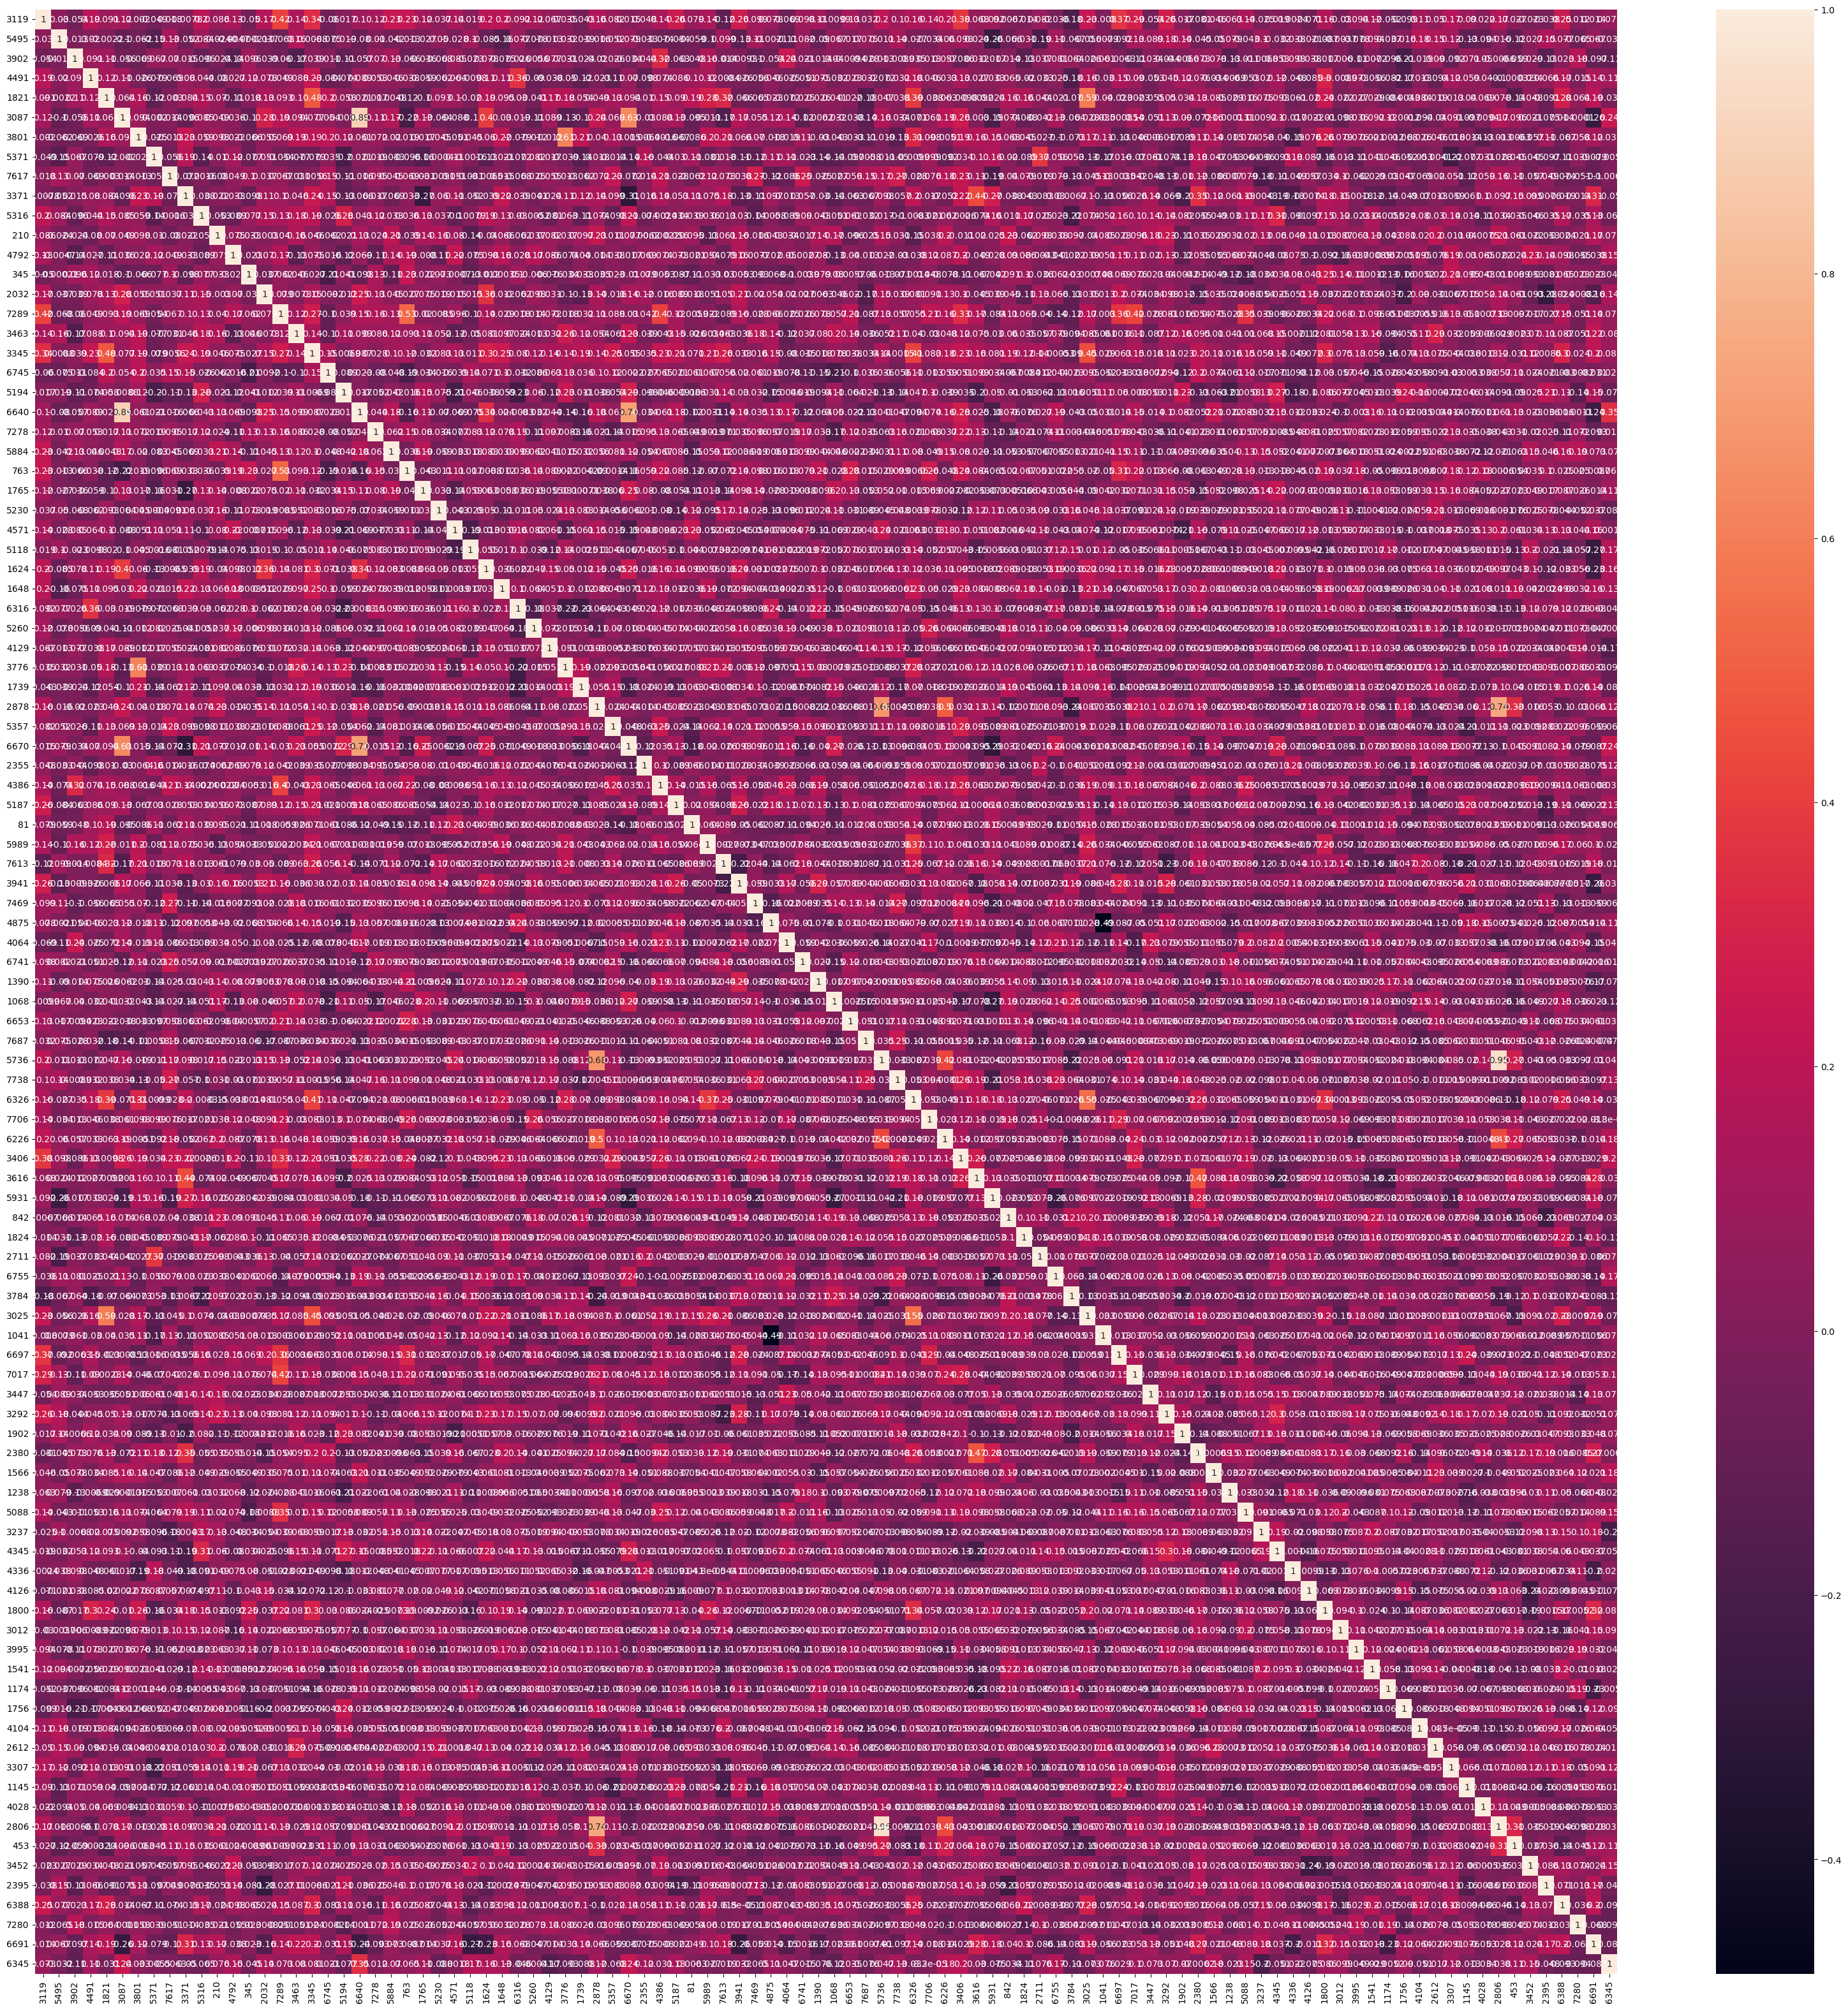

In [65]:
#checking correlation to see if we have to perform more feature reduction. It doesn't look like we have very much overlap between the features so it looks like we don't have to
plt.figure(figsize=(40,40))
sns.heatmap(data_df.corr(), annot=True)
plt.show()



In [7]:
X_train, X_test, y_train, y_test = train_test_split(data_df, labels_df, test_size = 0.15, random_state = 20)
print ('The size of our training "X" (input features) is', X_train.shape)
print ('\n')
print ('The size of our testing "X" (input features) is', X_test.shape)
print ('\n')
print ('The size of our training "y" (output feature) is', y_train.shape)
print ('\n')
print ('The size of our testing "y" (output features) is', y_test.shape)

The size of our training "X" (input features) is (148, 7264)


The size of our testing "X" (input features) is (27, 7264)


The size of our training "y" (output feature) is (148, 1)


The size of our testing "y" (output features) is (27, 1)


In [8]:
classifier = RandomForestClassifier(max_features = 0.05, n_estimators = 50, max_depth = 200, criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

/var/folders/z2/z4rmk79963l_trmcdlb01zsw0000gn/T/ipykernel_26109/3772124414.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier.fit(X_train, y_train)


RandomForestClassifier(criterion='entropy', max_depth=200, max_features=0.05,
                       n_estimators=50, random_state=0)

In [9]:
#using the trained model to predict the values given the test data
y_predict = classifier.predict(X_test)

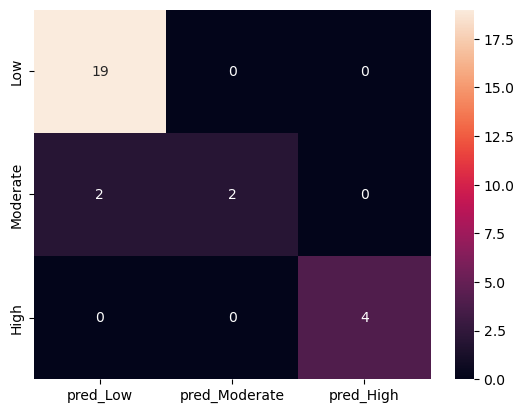

In [10]:
#setting up a visual to understand how many matches and mismatches there are between the real data and predicted data
cm = np.array(confusion_matrix(y_test, y_predict, labels=[1,2,3]))
confusion = pd.DataFrame(cm, index=['Low', 'Moderate', 'High'],
                         columns=['pred_Low','pred_Moderate','pred_High'])
sns.heatmap(confusion, annot=True)
plt.show()

In [10]:
print(classification_report(y_test, y_predict))

#these stats are good, a 93% accuracy is the best I've gotten, but there's a chance that I'm overfitting the model with the training data available to the model. To make it more generalized, I'm going to vary the random state of the train and test data split while tuning the parameters to find the best model. 

              precision    recall  f1-score   support

           1       0.90      1.00      0.95        19
           2       1.00      0.50      0.67         4
           3       1.00      1.00      1.00         4

    accuracy                           0.93        27
   macro avg       0.97      0.83      0.87        27
weighted avg       0.93      0.93      0.92        27



In [77]:
#this code was developed to run through many random states from 1-20 for the training data set. I did this to make sure that no matter how the data is split, the model still maintains a high accuracy for the prediction of data
from statistics import mean
accuracy_list = []

for x in range(20):
    X_train, X_test, y_train, y_test = train_test_split(data_df, labels_df, test_size = 0.20, random_state = x)
    classifier = RandomForestClassifier(max_features = 0.3, n_estimators = 100, max_depth = 20, min_samples_leaf = 8, criterion = 'entropy', random_state = 0)
    classifier.fit(X_train, y_train)
    y_predict = classifier.predict(X_test)
    rep = classification_report(y_test,y_predict).split("\n")
    for num in rep[6].split(" "):
        if "." in num:
            accuracy_list.append(float(num))   
            
print(mean(accuracy_list))
print(accuracy_list)

/var/folders/z2/z4rmk79963l_trmcdlb01zsw0000gn/T/ipykernel_26109/446282627.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier.fit(X_train, y_train)
/var/folders/z2/z4rmk79963l_trmcdlb01zsw0000gn/T/ipykernel_26109/446282627.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier.fit(X_train, y_train)
/var/folders/z2/z4rmk79963l_trmcdlb01zsw0000gn/T/ipykernel_26109/446282627.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier.fit(X_train, y_train)
/var/folders/z2/z4rmk79963l_trmcdlb01zsw0000gn/T/ipykernel_26109/446282627.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape 

0.781
[0.77, 0.89, 0.71, 0.83, 0.86, 0.86, 0.71, 0.77, 0.66, 0.8, 0.77, 0.8, 0.86, 0.66, 0.71, 0.71, 0.83, 0.8, 0.71, 0.91]


In [ ]:
# Here are some of the accuracies I saw while completing parameter tuning. With the final set of parameters, I found
# that they would yield the highest accuracies regardless of the random states that were applied to the train/test data
# attribution. There are many reasons why the accuracy is not consistently at a high level. One possiblity could be
# that the data has a lot of NaN values which was replaced by a 0 in pre-processing. These 0's could be messing with
# the model development and causing lower accuracy levels than normal. Another reason could be that not enough
# or too much feature reduction was done which caused a high or low accuracy than in reality. Overall, however,
# accuracies ranging in the high 70s, low 80s percentage-wise is relatively good as a tool that can assist scientists in
# making more accurate decisions on what a patient's TCE exposure could be.

# max_features = 0.5, n_estimators = 50, max_depth = 100 acc = 0.76
# max_features = 0.5, n_estimators = 100, max_depth = 200 acc = 0.785
# max_features = 0.3, n_estimators = 100, max_depth = 20 acc = 0.788
# max_features = 0.3, n_estimators = 100, max_depth = 20, min_samples_leaf = 8 acc = 0.782